C:\Users\kaan\AppData\Local\Temp\ipykernel_19784\1689738467.py:131: RuntimeWarning: Mean of empty slice
  r_mean = np.nanmean(r_cropped, axis=0)
C:\Users\kaan\AppData\Local\Temp\ipykernel_19784\1689738467.py:162: RuntimeWarning: Mean of empty slice
  b_mean = np.nanmean(b_cropped, axis=0)
C:\Users\kaan\AppData\Local\Temp\ipykernel_19784\1689738467.py:162: RuntimeWarning: Mean of empty slice
  b_mean = np.nanmean(b_cropped, axis=0)
C:\Users\kaan\AppData\Local\Temp\ipykernel_19784\1689738467.py:131: RuntimeWarning: Mean of empty slice
  r_mean = np.nanmean(r_cropped, axis=0)
C:\Users\kaan\AppData\Local\Temp\ipykernel_19784\1689738467.py:162: RuntimeWarning: Mean of empty slice
  b_mean = np.nanmean(b_cropped, axis=0)
C:\Users\kaan\AppData\Local\Temp\ipykernel_19784\1689738467.py:131: RuntimeWarning: Mean of empty slice
  r_mean = np.nanmean(r_cropped, axis=0)
C:\Users\kaan\AppData\Local\Temp\ipykernel_19784\1689738467.py:162: RuntimeWarning: Mean of empty slice
  b_mean = np.nanmean(b_cr

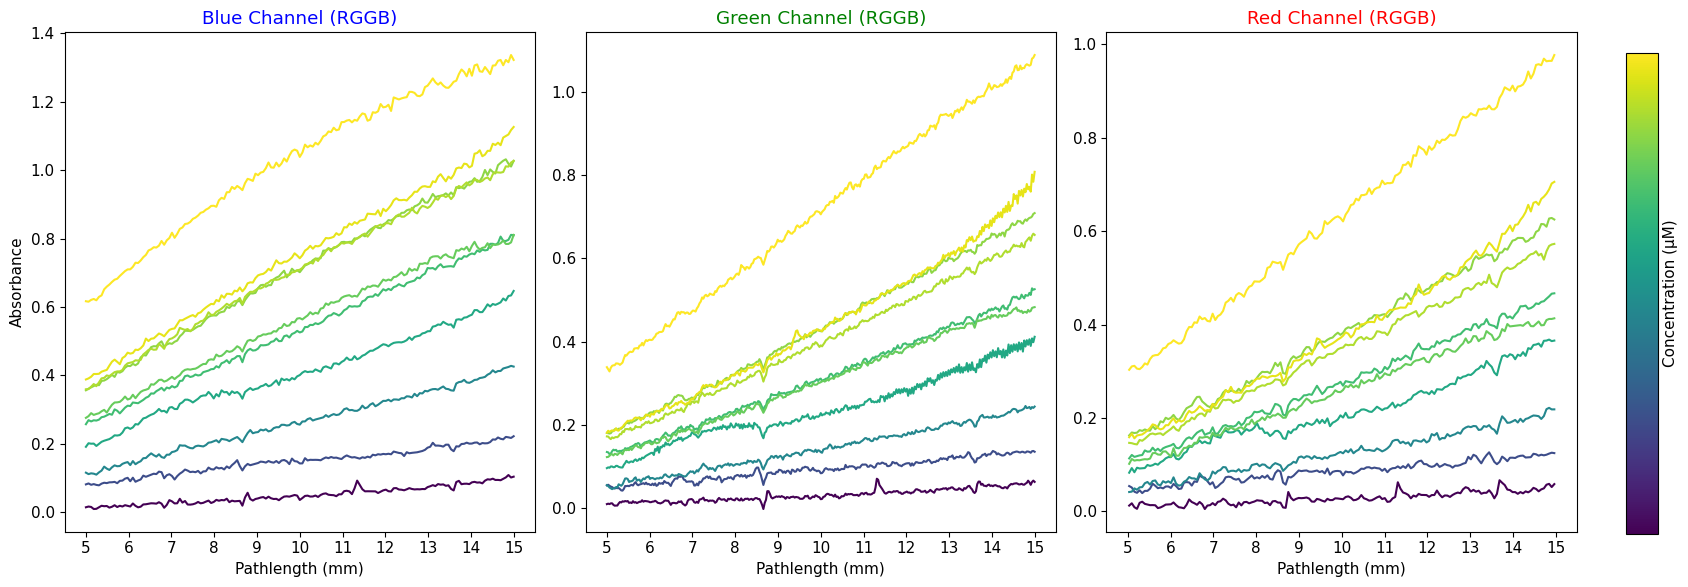

In [ ]:
import rawpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, NullLocator


'''
The coordinates are in the format [x, y, weight, height].

Be sure you read the Rawpy documentation to understand how they process the RAW image data.
'''

base_path = r"images"  

# Updated crop coordinates
crop_coords = {
    'blank': [2420, 1722, 329, 24],
    '0.0025g': [2420, 1722, 329, 24],
    '0.005g': [2417, 1793, 329, 24],
    '0.01g': [2275, 1730, 329, 24],
    '0.015g': [2273, 1743, 329, 24],
    '0.02g': [2374, 1762, 329, 24],
    '0.025g': [2348, 1697, 329, 24],
    '0.03g': [2254, 1720, 329, 24],
    '0.035g': [2343, 1778, 329, 24],
    '0.045g': [2317, 1716, 329, 24],
    '0.05g': [2301, 1712, 329, 24]
}


def adjust_to_r_pixel(coords):
    """Adjust coordinates to start from R pixel in RGGB pattern"""
    x, y, w, h = coords
    # Ensure x starts on an even column (R pixel)
    if x % 2 != 0:
        x -= 1
    # Ensure y starts on an even row (R pixel)
    if y % 2 != 0:
        y -= 1
    return [y, x, h, w]

# Transform coordinates and apply R pixel adjustment
crop_coords = {key: adjust_to_r_pixel(coords) 
               for key, coords in crop_coords.items()}

# Process data for each RGB channel separately to handle NaN columns
def process_dng_file(filename, crop_coords):
    """
    Process DNG file and extract RGB channels with proper handling of Bayer pattern
    Returns cropped RGB channels with zeros replaced by NaN
    """
    file_path = os.path.join(base_path, f'{filename}.dng')
    with rawpy.imread(file_path) as raw:
        # Get raw data and apply black level correction
        raw_data = raw.raw_image_visible.copy()
        raw_data = np.maximum(raw_data - 4096, 0)
        pattern = raw.raw_pattern
        
        # Get dimensions
        height, width = raw_data.shape

        # Create masks for R/G/B channels
        r_mask = np.zeros((height, width), dtype=bool)
        g_mask = np.zeros_like(r_mask)
        b_mask = np.zeros_like(r_mask)

        # Create index grids for Bayer pattern
        rows, cols = np.indices((height, width))
        mod_rows = rows % 2
        mod_cols = cols % 2

        # Generate masks based on Bayer pattern
        for r in range(2):
            for c in range(2):
                color_code = pattern[r, c]
                mask = (mod_rows == r) & (mod_cols == c)
                if color_code == 0:  # Red
                    r_mask[mask] = True
                elif color_code == 1:  # Green
                    g_mask[mask] = True
                elif color_code == 2:  # Blue
                    b_mask[mask] = True
                elif color_code == 3:  # Second green pixel
                    g_mask[mask] = True

        # Create and fill channel arrays
        r_channel = np.zeros_like(raw_data)
        g_channel = np.zeros_like(raw_data)
        b_channel = np.zeros_like(raw_data)

        r_channel[r_mask] = raw_data[r_mask]
        g_channel[g_mask] = raw_data[g_mask]
        b_channel[b_mask] = raw_data[b_mask]

        # Crop channels
        y, x, h, w = crop_coords
        r_cropped = r_channel[y:y+h, x:x+w]
        g_cropped = g_channel[y:y+h, x:x+w]
        b_cropped = b_channel[y:y+h, x:x+w]

        # Replace zeros with NaN
        r_cropped = np.where(r_cropped == 0, np.nan, r_cropped)
        g_cropped = np.where(g_cropped == 0, np.nan, g_cropped)
        b_cropped = np.where(b_cropped == 0, np.nan, b_cropped)

        return r_cropped, g_cropped, b_cropped

# Create separate DataFrames for each channel
r_df = pd.DataFrame()
g_df = pd.DataFrame()
b_df = pd.DataFrame()

# Process all files
for filename, coords in crop_coords.items():
    r_cropped, g_cropped, b_cropped = process_dng_file(filename, coords)
    
    # Set up column naming
    if filename == 'blank':
        prefix = 'blank'
    else:
        prefix = filename.replace('g', '')
    
    # Create pathlength
    #  array
    pathlength = np.linspace(5, 15, r_cropped.shape[1])
    
    # Process each channel separately
    # Red channel
    r_mean = np.nanmean(r_cropped, axis=0)
    r_valid = ~np.isnan(r_mean)
    if np.any(r_valid):
        r_data = r_mean[r_valid]
        r_path = pathlength[r_valid]
        r_channel_df = pd.DataFrame({
            f'{prefix}': r_data,
            'pathlength': r_path
        })
        if r_df.empty:
            r_df = r_channel_df
        else:
            r_df = pd.merge(r_df, r_channel_df, on='pathlength', how='outer')

    
    # Green channel
    g_mean = np.nanmean(g_cropped, axis=0)
    g_valid = ~np.isnan(g_mean)
    if np.any(g_valid):
        g_data = g_mean[g_valid]
        g_path = pathlength[g_valid]
        g_channel_df = pd.DataFrame({
            f'{prefix}': g_data,
            'pathlength': g_path
        })
        if g_df.empty:
            g_df = g_channel_df
        else:
            g_df = pd.merge(g_df, g_channel_df, on='pathlength', how='outer')
    
    # Blue channel
    b_mean = np.nanmean(b_cropped, axis=0)
    b_valid = ~np.isnan(b_mean)
    if np.any(b_valid):
        b_data = b_mean[b_valid]
        b_path = pathlength[b_valid]
        b_channel_df = pd.DataFrame({
            f'{prefix}': b_data,
            'pathlength': b_path
        })
        if b_df.empty:
            b_df = b_channel_df
        else:
            b_df = pd.merge(b_df, b_channel_df, on='pathlength', how='outer')
            
            
# Drop rows where all values are NaN
r_df.dropna(axis = 0, how='any', inplace=True)
g_df.dropna(axis = 0, how='any', inplace=True) 
b_df.dropna(axis = 0, how='any', inplace=True)

# Reset indices after dropping rows
r_df.reset_index(drop=True, inplace=True)
g_df.reset_index(drop=True, inplace=True)
b_df.reset_index(drop=True, inplace=True)

# Calculate absorbance for RGGB pattern data
concentrations = ['0.0025', '0.005', '0.01', '0.015',
                 '0.02', '0.025', '0.03', '0.035', 
                 '0.045', '0.05']

# Calculate absorbance for RGGB pattern data
for conc in concentrations:
    # Original RGGB pattern data
    if conc in r_df.columns and 'blank' in r_df.columns:
        r_df[f'{conc}_abs'] = np.log10(r_df['blank'] / r_df[conc])
    if conc in g_df.columns and 'blank' in g_df.columns:
        g_df[f'{conc}_abs'] = np.log10(g_df['blank'] / g_df[conc])
    if conc in b_df.columns and 'blank' in b_df.columns:
        b_df[f'{conc}_abs'] = np.log10(b_df['blank'] / b_df[conc])

# Plot results - Only RGGB channels
plot_concentrations = [0.0025, 0.005, 0.01, 0.015,
                      0.02, 0.025, 0.03, 0.035, 0.045, 0.05]
fig, axes = plt.subplots(1, 3, figsize=(16, 6))  # Changed to 1 row, 3 columns
plt.rcParams.update({'font.size': 11})

# Setup colormap
norm = plt.Normalize(np.log10(min(plot_concentrations)), np.log10(max(plot_concentrations)))
cmap = plt.cm.viridis

# Common plot settings
xlim = (4.5, 15.5)
xticks = np.arange(5, 16, 1)

# Plot original RGGB channels
for conc in plot_concentrations:
    color = cmap(norm(np.log10(float(conc))))
    
    # Plot each channel
    if f'{conc}_abs' in b_df.columns:
        axes[0].plot(b_df['pathlength'], b_df[f'{conc}_abs'], 
                    color=color, label=f'{conc}g')
    if f'{conc}_abs' in g_df.columns:
        axes[1].plot(g_df['pathlength'], g_df[f'{conc}_abs'], 
                    color=color, label=f'{conc}g')
    if f'{conc}_abs' in r_df.columns:
        axes[2].plot(r_df['pathlength'], r_df[f'{conc}_abs'], 
                    color=color, label=f'{conc}g')

# Configure all axes
titles = ['Blue Channel (RGGB)', 'Green Channel (RGGB)', 'Red Channel (RGGB)']
colors = ['blue', 'green', 'red']

for j in range(3):
    ax = axes[j]
    ax.set_title(titles[j], color=colors[j])
    ax.set_xlabel('Pathlength (mm)')
    ax.set_ylabel('Absorbance' if j == 0 else '')
    ax.set_xticks(xticks)
    ax.set_xlim(xlim)
    #ax.set_ylim(-0.05, 1.6)

# Add colorbar with logarithmic spacing
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])  # [left, bottom, width, height]

# Create logarithmically spaced ticks
tick_locations = [1, 10]
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.log10(tick_locations))
cbar.set_ticklabels([str(tick) for tick in tick_locations])

# Configure tick locations and appearance
cbar.ax.yaxis.set_major_locator(FixedLocator(np.log10(tick_locations)))
cbar.ax.yaxis.set_minor_locator(NullLocator())
cbar.ax.tick_params(which='both', width=0, length=0)
cbar.set_label('Concentration (µM)')

plt.tight_layout()
plt.show()

In [8]:
'''This is to save the data in one CSV file and for further linear regression analysis'''

# Create final DataFrame to combine all data
final_df = pd.DataFrame()

# Use pathlength column from r_df as the base
final_df['pathlength'] = r_df['pathlength']

# Add columns from RGGB pattern data (r_df, g_df, b_df)
concentrations = ['0.0025', '0.005', '0.01', '0.015',
                 '0.02', '0.025', '0.03', '0.035', 
                 '0.045', '0.05']

# Add both raw intensity and absorbance data
for conc in concentrations:
    # Add raw intensity columns
    if conc in r_df.columns:
        final_df[f'{conc}R'] = r_df[conc]
    if conc in g_df.columns:
        final_df[f'{conc}G'] = g_df[conc]
    if conc in b_df.columns:
        final_df[f'{conc}B'] = b_df[conc]
    
    # Add absorbance columns
    if f'{conc}_abs' in r_df.columns:
        final_df[f'{conc}R_abs'] = r_df[f'{conc}_abs']
    if f'{conc}_abs' in g_df.columns:
        final_df[f'{conc}G_abs'] = g_df[f'{conc}_abs']
    if f'{conc}_abs' in b_df.columns:
        final_df[f'{conc}B_abs'] = b_df[f'{conc}_abs']

# Add blank columns if they exist
if 'blank' in r_df.columns:
    final_df['blankR'] = r_df['blank']
if 'blank' in g_df.columns:
    final_df['blankG'] = g_df['blank']
if 'blank' in b_df.columns:
    final_df['blankB'] = b_df['blank']

# Sort by pathlength and reset index
final_df.sort_values('pathlength', inplace=True)
final_df.reset_index(drop=True, inplace=True)

# Save to CSV
final_df.to_csv('DNG_pi_data.csv', index=False)

print(f"Data saved to DNG_pi_data.csv with {len(final_df)} rows and {len(final_df.columns)} columns")

Data saved to DNG_pi_data.csv with 164 rows and 64 columns
